In [30]:
import pandas as pd
import random
from collections import Counter

In [31]:
# Some constants
pos_dataset_file = '../data/corpus/pos_dataset.csv'
neg_dataset_file = '../data/corpus/neg_dataset.csv'
overall_table_file = '../data/corpus/overall_table.csv'
entity_file = '../data/corpus/entity.txt'

In [21]:
# pos_df = pd.read_csv(pos_dataset_file)
# neg_df = pd.read_csv(neg_dataset_file)
# pos_df['len'] = pos_df.apply(lambda row: len(row['path'].split()), axis=1)
# neg_df['len'] = neg_df.apply(lambda row: len(row['path'].split()), axis=1)
df = pd.read_csv(overall_table_file)

In [22]:
df.head()

,sent_id,sent_len,head_kw_id,tail_kw_id,dep_path,npmi,kw_dist
0,0,13,530,211,conj,0.192697,2
1,0,13,530,211,i_conj,0.192697,2
2,0,13,530,13405,i_pobj i_prep,0.278913,2
3,0,13,530,13405,pobj prep,0.278913,2
4,0,13,530,58743,prep pobj,0.128319,5


In [23]:
# Path check
sub_df = df[df['dep_path'] == 'compound'][:100]

In [24]:
sub_df.head()

,sent_id,sent_len,head_kw_id,tail_kw_id,dep_path,npmi,kw_dist
115,2,51,9484,1616,compound,0.127813,1
208,3,16,40488,57322,compound,0.414777,1
235,4,32,6690,15163,compound,0.038545,1
273,4,32,41774,6580,compound,0.217129,1
303,4,32,6580,14652,compound,0.136663,1


In [25]:
entity = open(entity_file).read().split('\n')

In [26]:
entity[14652]

'operator'

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from typing import Dict, List
nlp = spacy.load('en_core_web_sm')

In [28]:
def build_dep_graph(sent:str):
    doc = nlp(sent)
    noun_chunks_text = [span.text for span in doc.noun_chunks]
    noun_chunks_idx = [span[-1].i for span in doc.noun_chunks]
    tree = nx.DiGraph()
    for i in range(len(noun_chunks_idx)):
        tree.add_node(noun_chunks_idx[i], t=noun_chunks_text[i])
    for i in noun_chunks_idx:
        pointer = i
        while doc[pointer].dep_ != 'ROOT':
            parent = doc[pointer].head
            if not tree.has_node(parent.i):
                tree.add_node(parent.i, t=parent.text)
            tree.add_edge(parent.i, pointer)
            pointer = parent.i
    return tree, noun_chunks_idx, noun_chunks_text

def show_graph(g:nx.DiGraph):
    labels = nx.get_node_attributes(g, 't')
    # nx.draw_networkx(tree, with_labels=True, labels=labels)
    nx.draw_networkx(g, with_labels=True)
    plt.figure(figsize=(24, 24))
    plt.show()


In [32]:
sent = 'Lucille Clifton, whom he married in 1958, was born in 1936.'
g, noun_chunks_idx, noun_chunks_text = build_dep_graph(sent)

In [15]:
def cal_matrix(g:nx.DiGraph):
    node_num = len(g.nodes)
    P = np.zeros((node_num, node_num))
    node2idx = {node : i for i, node in enumerate(g.nodes)}
    for node in g.nodes:
        in_degree, out_degree = g.in_degree(node), g.out_degree(node)
        weight_sum = (in_degree * 0.5) + (out_degree * 1)
        for neighbor in g.neighbors(node):
            P[node2idx[node], node2idx[neighbor]] = 1. / weight_sum
        for pre in g.predecessors(node):
            P[node2idx[node], node2idx[pre]] = 0.5 / weight_sum
    A = np.append(np.transpose(P) - np.identity(node_num), [[1] * node_num], axis=0)
    b = np.transpose(np.array(([0] * node_num) + [1]))
    pi = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))
    D = np.diag(pi)
    E = np.ones((node_num, node_num))
    Z = np.linalg.inv(np.identity(node_num) - P + E.dot(D)) - E.dot(D)
    M = - (Z - Z.diagonal()) / pi
    return M, node2idx

In [33]:
M, node2idx = cal_matrix(g)

In [12]:
def get_entity_matrix(M:np.ndarray, node2idx:Dict, noun_chunks_idx:List[int]):
    noun_chunks_set = set([node2idx[i] for i in noun_chunks_idx])
    mask = np.array([i in noun_chunks_set for i in range(len(M))], dtype=np.bool)
    return (M[mask].T)[mask].T

def get_act_matrix(m:np.ndarray):
    return m + m.T

def get_summary_table(m:np.ndarray, noun_chunks_text:List[str]):
    df = pd.DataFrame(m, columns = noun_chunks_text)
    df['_'] = noun_chunks_text
    return df

In [34]:
m = get_entity_matrix(M, node2idx=node2idx, noun_chunks_idx=noun_chunks_idx)
m = get_act_matrix(m)
print(sent)
get_summary_table(m, noun_chunks_text)

Lucille Clifton, whom he married in 1958, was born in 1936.


,Lucille Clifton,whom,he,_
0,-0.0,16.5,16.5,Lucille Clifton
1,16.5,-0.0,11.0,whom
2,16.5,11.0,-0.0,he


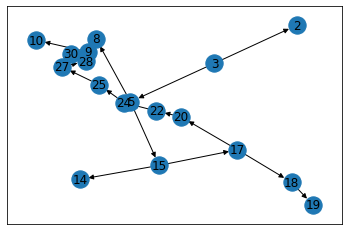

<Figure size 1728x1728 with 0 Axes>

2: the basic idea
8: a local_interaction rule
10: agent
14: their state_trajectory
17: a linear_combination
19: sinusoid
24: frequency function
27: the eigenvalue
30: the laplacian_matrix


In [11]:
show_graph(g)
for i in range(len(noun_chunks_idx)):
    print('%d: %s' % (noun_chunks_idx[i], noun_chunks_text[i]))